# Chapter 6: Handling Missing Data

## Data and libraries

In [1]:
# Common libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Chapter-specific libraries
from statsmodels.imputation import mice
import statsmodels.api as sm # For OLS call in Mice

In [14]:
#Loading the data
complete_data_df = pd.read_csv("chap6-complete_data.csv")
available_data_df = pd.read_csv("chap6-available_data.csv")
available_data_supp_df = pd.read_csv("chap6-available_data_supp.csv")

In [15]:
#Reformatting factor variables
complete_data_df['gender'] = pd.Categorical(complete_data_df.gender, 
                                      categories=['M','F'])
available_data_df['gender'] = pd.Categorical(available_data_df.gender, 
                                      categories=['M','F'])
complete_data_df['state'] = pd.Categorical(complete_data_df.state,
                                            categories=['A','B','C'])
available_data_df['state'] = pd.Categorical(available_data_df.state,
                                            categories=['A','B','C'])

## Visualizing missing data

### Amount of missing data

In [4]:
### Visualizing missing data "a la" VIM

#Identifying columns with any missinavailable_data_df.describe()

def md_pattern_fun(dat_df):
    # Getting all column names
    all_cols = dat_df.columns.tolist()
    # Getting the names of columns with some missing values
    miss_cols = [col for col in all_cols if dat_df[col].isnull().sum()]
    if miss_cols == all_cols: dat_df['index'] = dat_df.index
    # Removing columns with no missing values
    dat_df = dat_df.loc[:,miss_cols]
    #Showing total number of missing values per variable
    print(dat_df.isnull().sum()) 
    # Adding count value
    dat_df['count'] = 1
    # Showing count for missingness combinations
    print(dat_df.isnull().groupby(miss_cols).count())
    
md_pattern_fun(available_data_df)

extra       793
neuro      1000
state       711
bkg_amt     175
dtype: int64
                           count
extra neuro state bkg_amt       
False False False False      368
                  True        33
            True  False      163
                  True        24
      True  False False      358
                  True        23
            True  False      214
                  True        24
True  False False False      249
                  True        15
            True  False      125
                  True        23
      True  False False      228
                  True        15
            True  False      120
                  True        18


In [5]:
#Quantifying the amount of missing data for a variable   
min_data_df = available_data_df.copy()
min_data_df.neuro = np.where(min_data_df.neuro.isna(), min_data_df.neuro.min(), 
                             min_data_df.neuro)

max_data_df = available_data_df.copy()
max_data_df.neuro = np.where(max_data_df.neuro.isna(), max_data_df.neuro.max(), 
                             max_data_df.neuro)


print(ols("bkg_amt~neuro", data=min_data_df).fit().summary())
print(ols("bkg_amt~neuro", data=max_data_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                bkg_amt   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     25.24
Date:                Sat, 29 May 2021   Prob (F-statistic):           5.56e-07
Time:                        11:13:36   Log-Likelihood:                -10482.
No. Observations:                1825   AIC:                         2.097e+04
Df Residuals:                    1823   BIC:                         2.098e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    273.7854      9.382     29.181      0.0

### Correlation of missingness

In [6]:
#Loading the data
tacoma_df = pd.read_csv("chap6-tacoma.csv")
tampa_df = pd.read_csv("chap6-tampa.csv")

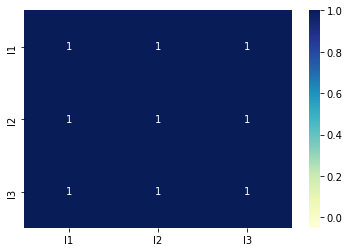

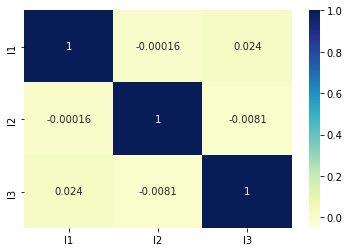

In [7]:
# Building the correlation matrices
tampa_miss_df = tampa_df.copy().drop(['ID'], axis=1).isna()
tacoma_miss_df = tacoma_df.copy().drop(['ID'], axis=1).isna()

tampa_cor = tampa_miss_df.corr()
tacoma_cor = tacoma_miss_df.corr()

sns.heatmap(tampa_cor, annot=True, vmin=-0.05, vmax=1, cmap="YlGnBu")
plt.show()
sns.heatmap(tacoma_cor, annot=True, vmin=-0.05, vmax=1, cmap="YlGnBu")
plt.show()

# Diagnosing Missing Data

## Diagnosing MCAR variables

In [8]:
#Sources of missingness for extraversion
available_data_df['md_extra'] = available_data_df['extra'].isnull().astype(float)
md_extra_mod =smf.logit('md_extra~age+open+neuro+gender+state+bkg_amt',
                      data=available_data_df)
md_extra_mod.fit().summary()

Optimization terminated successfully.
         Current function value: 0.672086
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               md_extra   No. Observations:                  617
Model:                          Logit   Df Residuals:                      609
Method:                           MLE   Df Model:                            7
Date:                Sat, 29 May 2021   Pseudo R-squ.:                0.003477
Time:                        11:13:48   Log-Likelihood:                -414.68
converged:                       True   LL-Null:                       -416.12
Covariance Type:            nonrobust   LLR p-value:                    0.8946
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.7235      0.705     -1.026      0.305      -2.105       0.658
gender[T.F]    -0.0237      0.166     -0.143      0.886      -0.349       0.302
state[T.B]     -0.0780      0.200     -0.390      0.696      -0.470       0.314
state[T.C]     -0.0556      0.205     -0.271      0.786      -0.457       0.346
age            -0.0016      0.009     -0.179      0.858      -0.019       0.016
open            0.0558      0.043      1.312      0.190      -0.028       0.139
neuro           0.0501      0.071      0.711      0.477      -0.088       0.188
bkg_amt        -0.0008      0.001     -0.681      0.496      -0.003       0.001
===============================================================================
"""

## Diagnosing MAR variables

In [9]:
#Sources of missingness for state
available_data_df['md_state'] = available_data_df['state'].isnull()\
    .astype(float)
md_state_mod =smf.logit('md_state~age+open+extra+neuro+gender+bkg_amt',
                      data=available_data_df)
md_state_mod.fit(disp=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               md_state   No. Observations:                  531
Model:                          Logit   Df Residuals:                      524
Method:                           MLE   Df Model:                            6
Date:                Sat, 29 May 2021   Pseudo R-squ.:                 0.01619
Time:                        11:13:52   Log-Likelihood:                -322.14
converged:                       True   LL-Null:                       -327.44
Covariance Type:            nonrobust   LLR p-value:                    0.1014
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2410      0.809     -0.298      0.766      -1.826       1.344
gender[T.F]    -0.1742      0.192     -0.907      0.364      -0.551       0.202
age             0.0206      0.010      2.035      0.042       0.001       0.040
open            0.0362      0.050      0.727      0.467      -0.061       0.134
extra           0.0078      0.048      0.162      0.871      -0.087       0.102
neuro          -0.1462      0.087     -1.687      0.092      -0.316       0.024
bkg_amt        -0.0019      0.001     -1.445      0.149      -0.005       0.001
===============================================================================
"""

## Diagnosing MNAR variables

In [10]:
#Sources of missingness for neuroticism
available_data_df['md_neuro'] = available_data_df['neuro'].isnull()\
    .astype(float)
md_neuro_mod =smf.logit('md_neuro~age+open+extra+state+gender+bkg_amt',
                      data=available_data_df)
md_neuro_mod.fit(disp=0).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               md_neuro   No. Observations:                  726
Model:                          Logit   Df Residuals:                      718
Method:                           MLE   Df Model:                            7
Date:                Sat, 29 May 2021   Pseudo R-squ.:                 0.01936
Time:                        11:13:56   Log-Likelihood:                -493.42
converged:                       True   LL-Null:                       -503.16
Covariance Type:            nonrobust   LLR p-value:                  0.006812
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.1629      0.458     -0.356      0.722      -1.060       0.735
state[T.B]      0.0471      0.182      0.259      0.796      -0.309       0.404
state[T.C]     -0.1283      0.188     -0.683      0.495      -0.497       0.240
gender[T.F]    -0.0935      0.151     -0.618      0.537      -0.390       0.203
age            -0.0126      0.008     -1.552      0.121      -0.029       0.003
open            0.0524      0.039      1.361      0.173      -0.023       0.128
extra          -0.0850      0.041     -2.092      0.036      -0.165      -0.005
bkg_amt         0.0032      0.001      3.020      0.003       0.001       0.005
===============================================================================
"""

## Handling missing data

In [16]:
#One-hot encoding categorical variable for gender
gender_dummies = pd.get_dummies(available_data_df.\
                                gender, 
                                prefix='gender')
available_data_df =  pd.concat([available_data_df, 
                                gender_dummies], 
                               axis=1)
available_data_df.gender_F = \
np.where(available_data_df.gender.isna(), 
         float('NaN'), available_data_df.gender_F)
available_data_df.gender_M = \
np.where(available_data_df.gender.isna(), 
         float('NaN'), available_data_df.gender_M)
available_data_df =  available_data_df.\
drop(['gender'], axis=1)

In [17]:
#One-hot encoding categorical variable for state
state_dummies = pd.get_dummies(available_data_df.state, prefix='state')
available_data_df =  pd.concat([available_data_df, state_dummies], axis=1)
available_data_df.state_A = np.where(available_data_df.state.isna(), 
                                     float('NaN'), available_data_df.state_A)
available_data_df.state_B = np.where(available_data_df.state.isna(), 
                                     float('NaN'), available_data_df.state_B)
available_data_df.state_C = np.where(available_data_df.state.isna(), 
                                     float('NaN'), available_data_df.state_C)
available_data_df =  available_data_df.drop(['state'], axis=1)

In [18]:
#MICE imputation
MI_data_df = mice.MICEData(available_data_df)                                 
fit = mice.MICE(model_formula='bkg_amt ~ age + open + extra + neuro + \
                gender_M + gender_F + state_A + state_B + state_C', 
                model_class=sm.OLS, data=MI_data_df)                
MI_summ = fit.fit(n_imputations=20).summary()  
print(MI_summ)

                           Results: MICE
Method:                  MICE         Sample size:          2000   
Model:                   OLS          Scale                 5008.39
Dependent variable:      bkg_amt      Num. imputations      20     
-------------------------------------------------------------------
           Coef.   Std.Err.    t    P>|t|   [0.025   0.975]   FMI  
-------------------------------------------------------------------
Intercept 122.2796   7.6950 15.8908 0.0000 107.1976 137.3615 0.3064
age        -1.1134   0.1787 -6.2315 0.0000  -1.4636  -0.7632 0.3184
open        3.1291   0.8709  3.5931 0.0003   1.4222   4.8359 0.1325
extra      11.2347   0.8877 12.6566 0.0000   9.4950  12.9745 0.1819
neuro      -5.3054   1.8266 -2.9045 0.0037  -8.8855  -1.7253 0.4475
gender_M   67.2171   4.2216 15.9223 0.0000  58.9429  75.4912 0.2815
gender_F   55.0625   4.1530 13.2584 0.0000  46.9227  63.2023 0.2601
state_A    41.5921   3.4257 12.1413 0.0000  34.8779  48.3063 0.2164
state_B

In [13]:
#Adding auxiliary variables
augmented_data_df = pd.concat([available_data_df, available_data_supp_df], 
                              axis=1)
MI_data_aux_df = mice.MICEData(augmented_data_df)   